In [1]:
from collections import defaultdict
import glob
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np

import pandas as pd
import seaborn


In [2]:
# example commands
# python validate_on_nic_DMI.py 2021-01-01 2021-12-31 /Data/sat/auxdata/ice_charts/NIC /Data/sat/auxdata/ice_charts/dmi_asip_seaice_mosaic_arc_l3 ./nic_dmi
# python validate_on_nic_NERSC.py 2023-01-01 2023-03-31 /Data/sat/auxdata/ice_charts/NIC /Data/sat/auxdata/ice_charts/NERSC/nrt.cmems-du.eu/Core/SEAICE_ARC_PHY_AUTO_L4_NRT_011_015/cmems_obs-si_arc_phy-icetype_nrt_L4-auto_P1D ./nic_nersc/

In [3]:
idir = './nic_dmi'
#idir = './nic_nersc'

frmt = '%Y%m%d.npz'
var_names = ['accuracy', 'macro_precision', 'macro_recall', 'macro_f1_score']
ice_var_names = ['precision', 'recall', 'fscore', 'total_man', 'total_aut']

values = defaultdict(list)
dates = []
confmatrs = []
ice_names = {}

ifiles = sorted(glob.glob(f'{idir}/*npz'))
for ifile in ifiles:
    d = dict(np.load(ifile, allow_pickle=True))
    ice_names = list(d['labels'])
    if 'none' in d:
        continue
    dates.append(datetime.strptime(ifile.split('_')[-1], frmt))
    for var_name in var_names:
        values[var_name].append(d[var_name].item())
    for ice_var_name in ice_var_names:
        ice_values = d[ice_var_name]
        if len(ice_values) < 4:
            ice_values = [np.nan, np.nan, np.nan, np.nan]
        for ice_name, ice_value in zip(ice_names, ice_values):
            var_name = f'{ice_name}_{ice_var_name}'
            values[var_name].append(ice_value)
    confmatrs.append(d['matrix'])


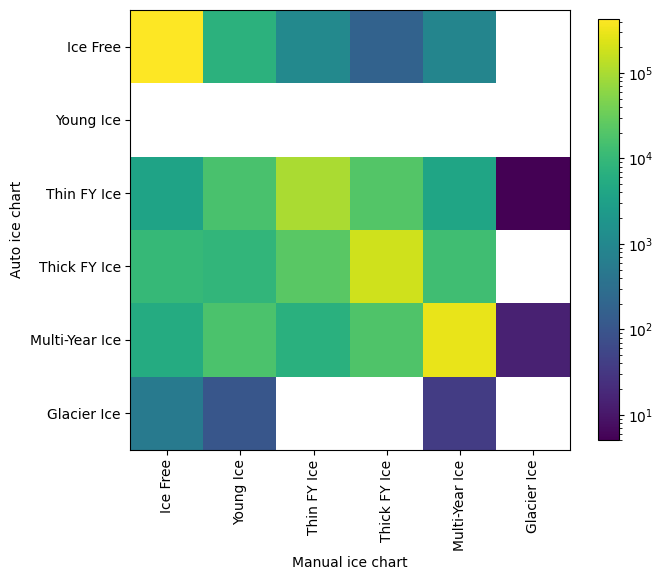

In [4]:
fig, axs = plt.subplots(1,1,figsize=(7,7))

m = np.dstack([m for m in confmatrs])
plt.colorbar(axs.imshow(m.sum(axis=2).T, norm=LogNorm()), ax=axs, shrink=0.7)
axs.set_xticks(range(len(ice_names)), ice_names, rotation=90)
axs.set_yticks(range(len(ice_names)), ice_names)
axs.set_xlabel('Manual ice chart')
axs.set_ylabel('Auto ice chart')
plt.tight_layout()
plt.savefig(f'{idir}/confusion_matrix.png', dpi=150, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [5]:
df = pd.DataFrame(values, index=dates)
df['month'] = df.index.strftime('%b')
show_names = df.columns.drop(['month'])

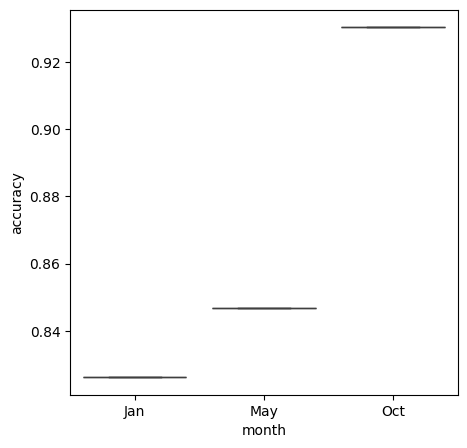

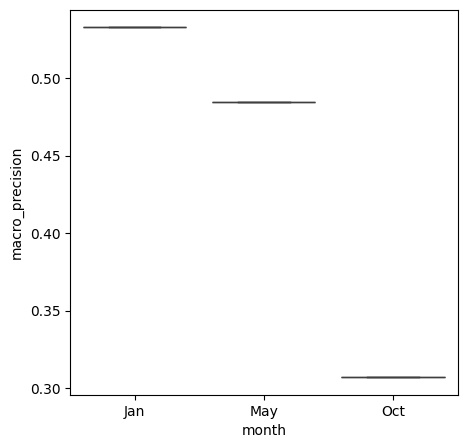

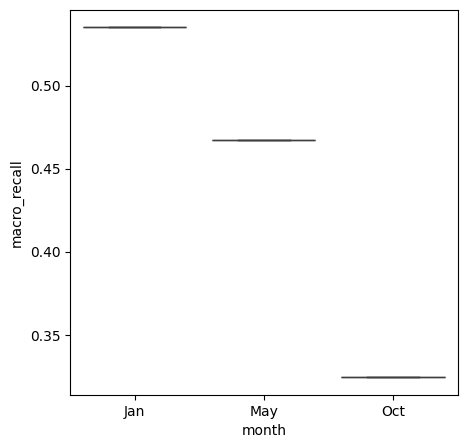

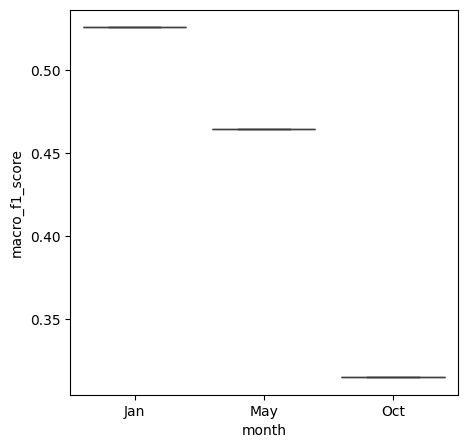

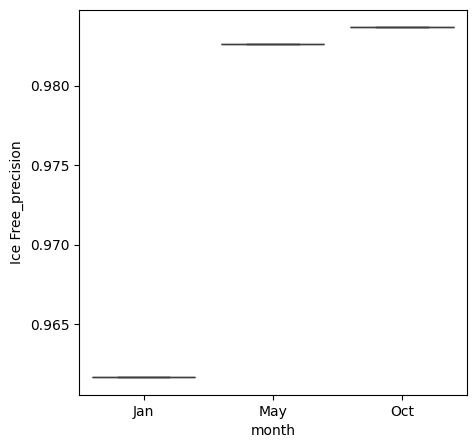

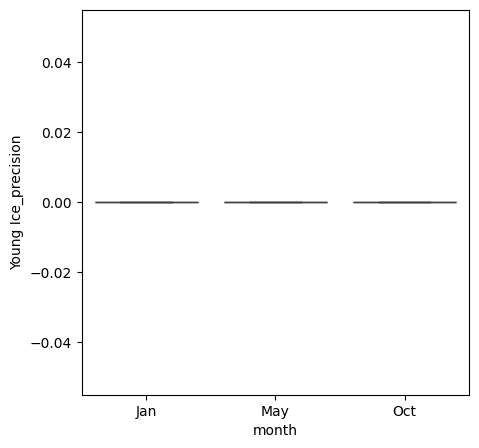

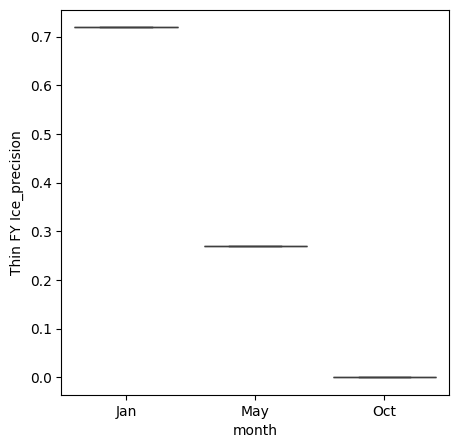

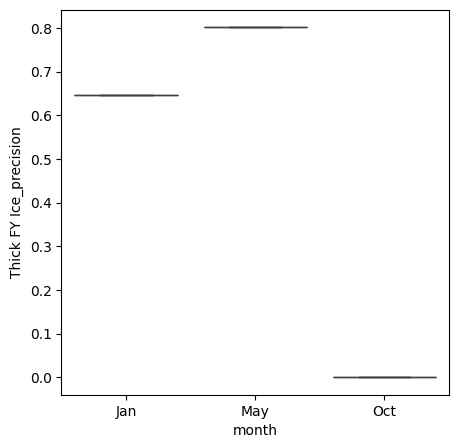

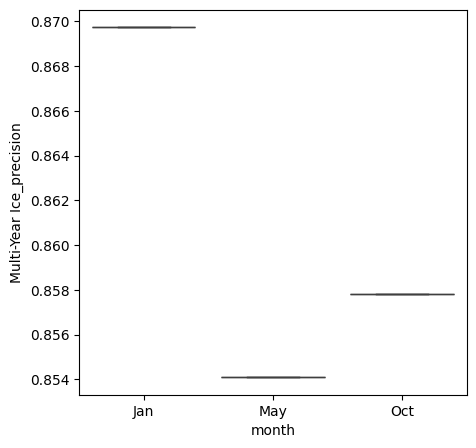

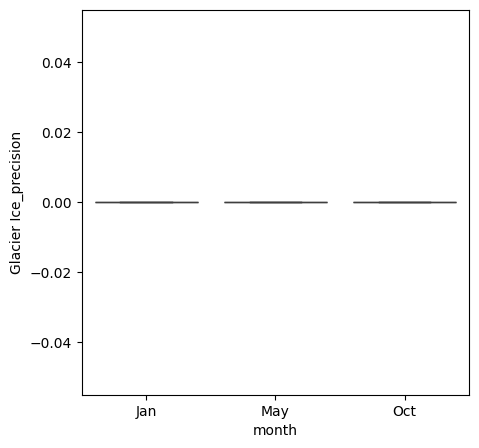

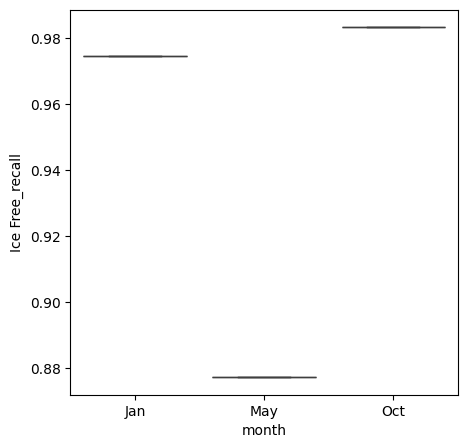

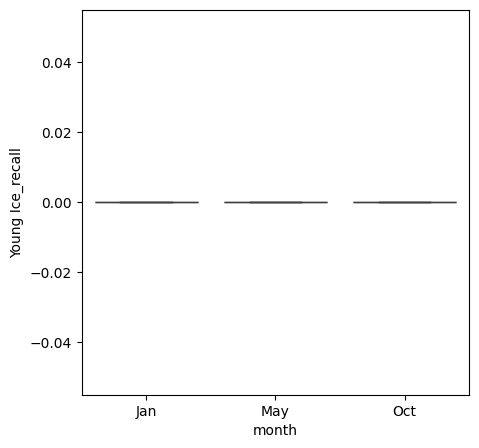

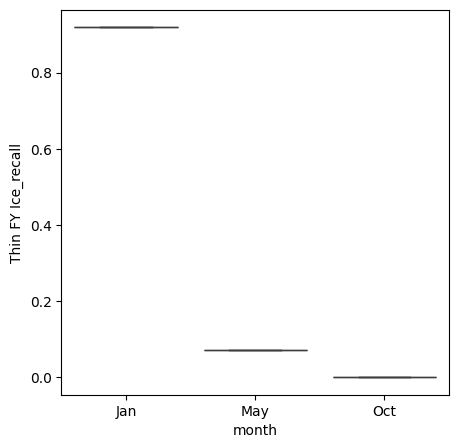

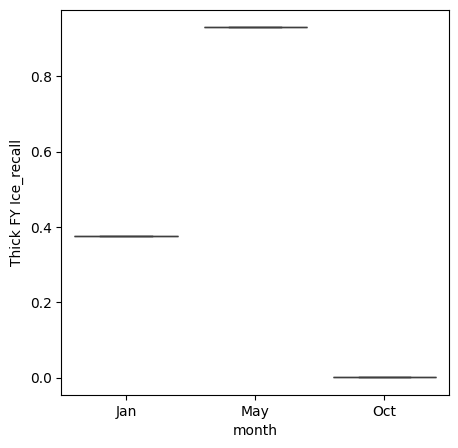

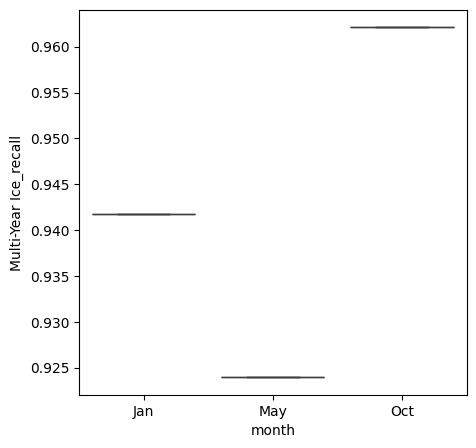

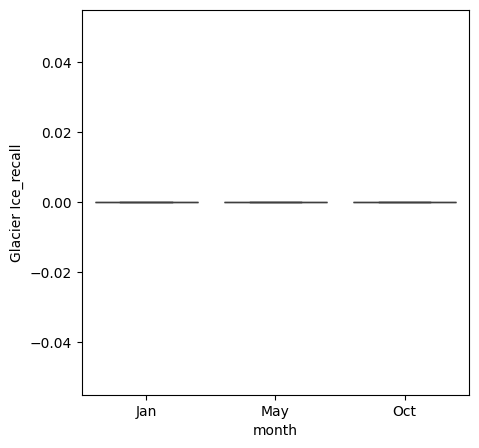

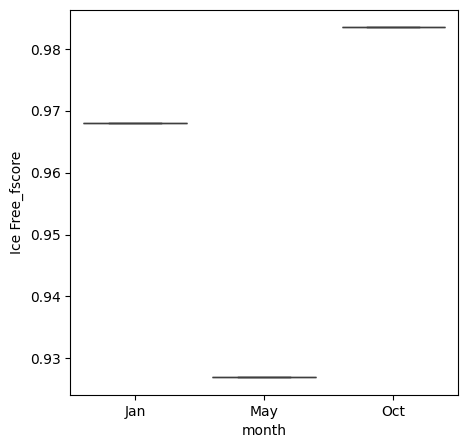

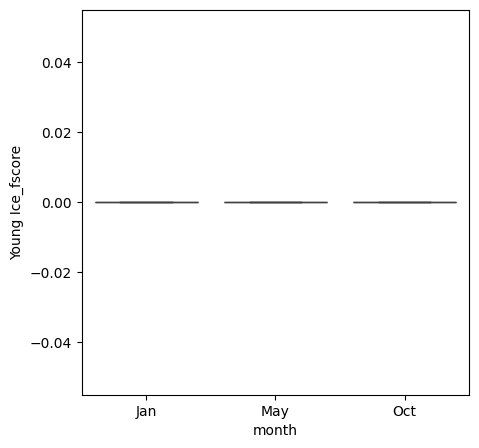

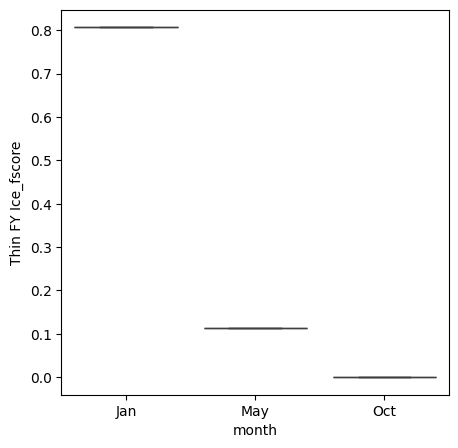

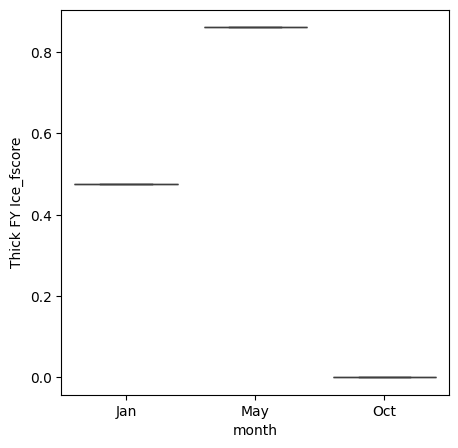

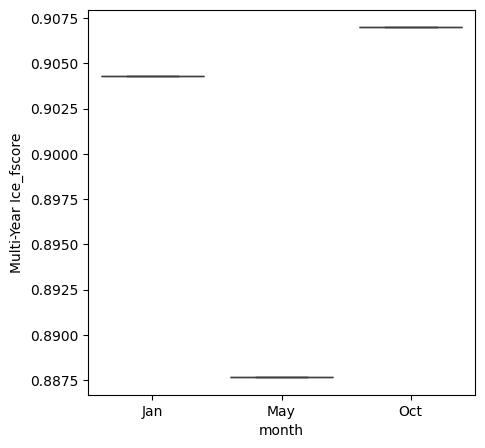

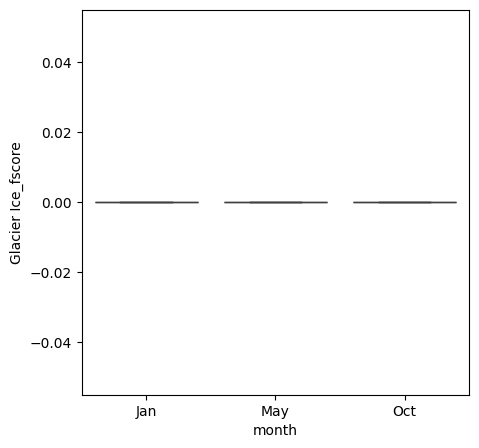

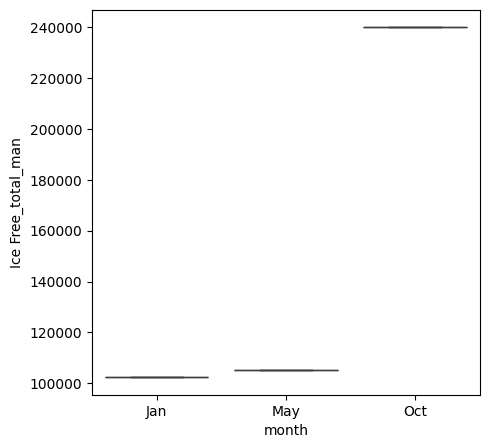

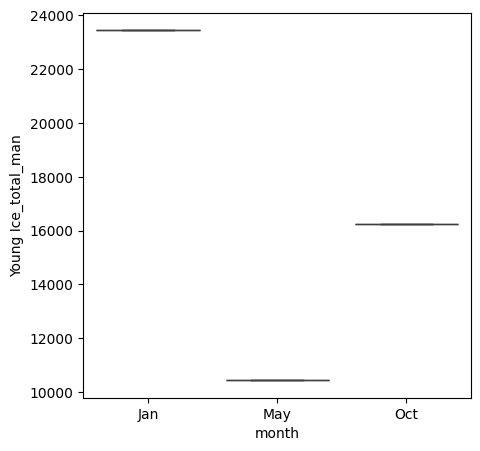

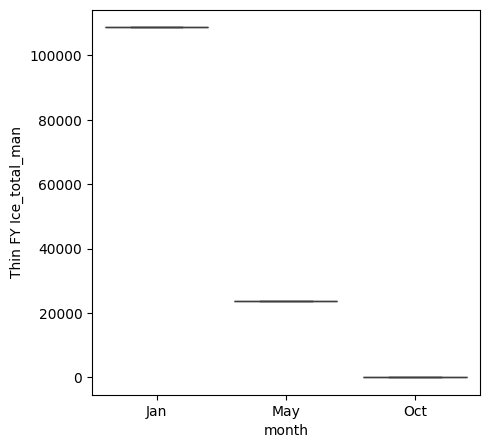

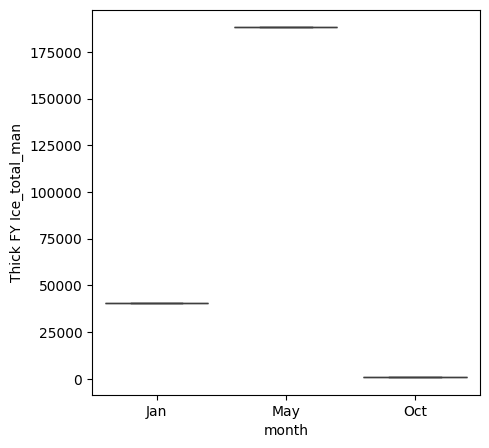

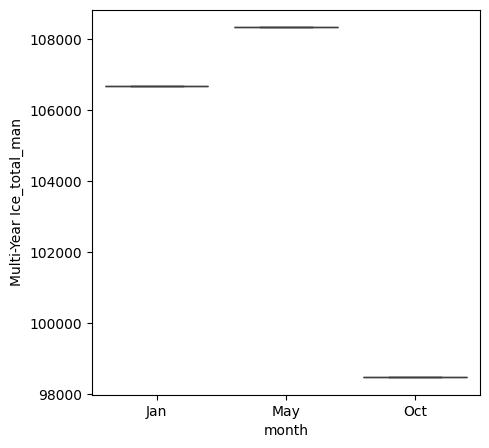

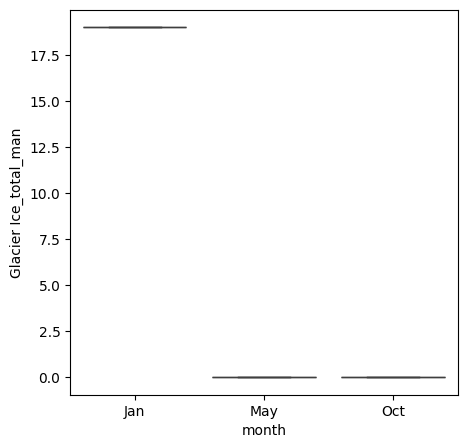

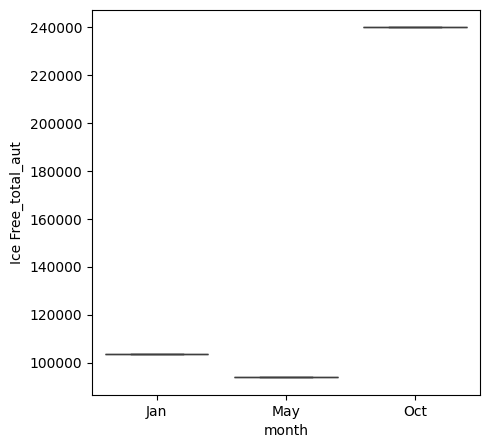

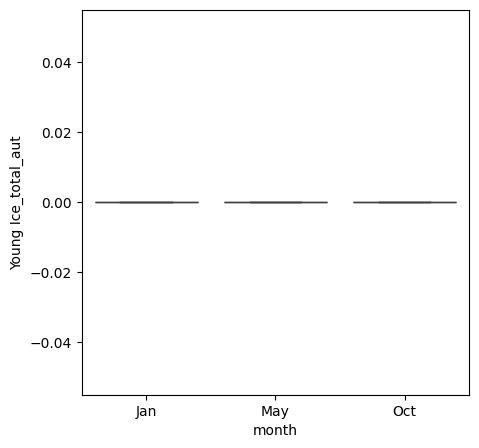

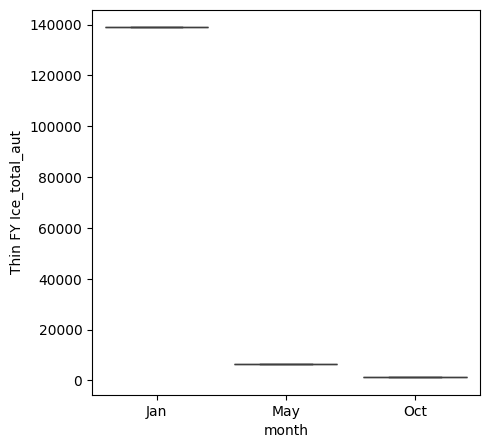

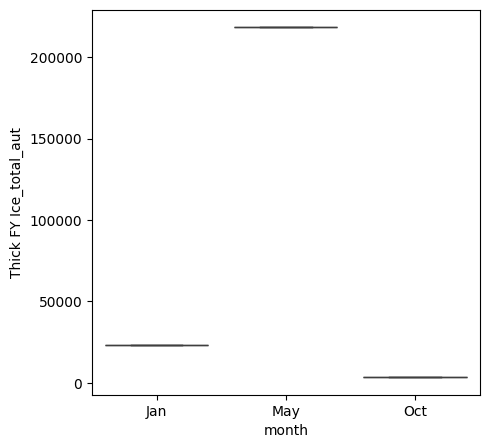

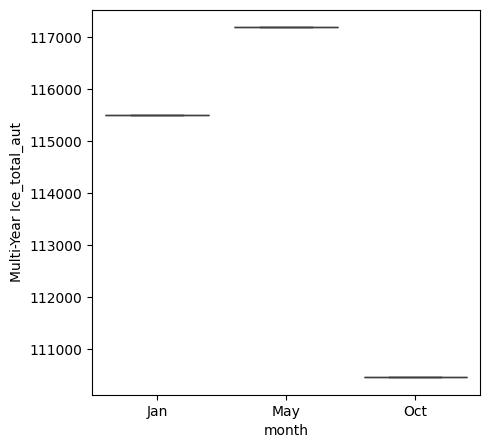

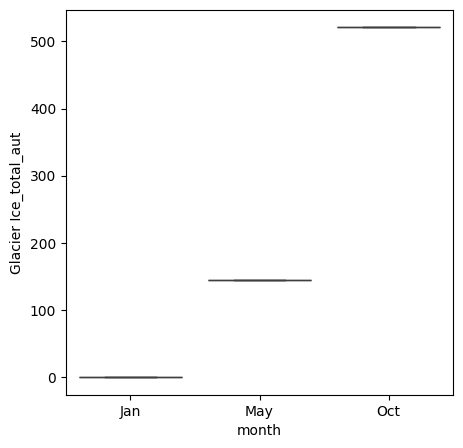

In [6]:
for var_name in show_names:
    fig, ax = plt.subplots(1,1,figsize=(5,5))
    seaborn.boxplot(x='month', y=var_name, data=df)
    plt.savefig(f'{idir}/{var_name}.png', dpi=200, bbox_inches='tight', pad_inches=0.1)
    plt.show()
